In [1]:
# =======================================================
# Este script incluye las correcciones sugeridas al trabajo original

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (silhouette_score, silhouette_samples, 
                             davies_bouldin_score, calinski_harabasz_score)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import plotly.express as px

In [2]:
df = pd.read_csv('SmartFarmingCropYield.csv')
df.columns = df.columns.str.strip()

print(f"Forma del dataset: {df.shape}")
print(f"Duplicados: {df.duplicated().sum()}")

Forma del dataset: (311, 14)
Duplicados: 0


In [3]:
# ==========================================================

# Para estadoEnfermedadesCultivo: mantener "Saludable" es razonable
df['estadoEnfermedadesCultivo'] = df['estadoEnfermedadesCultivo'].replace('Moderate', 'Moderado')
df['estadoEnfermedadesCultivo'] = df['estadoEnfermedadesCultivo'].fillna('Saludable')

# Para tipoRiego: evaluar si usar moda o crear categoría "Desconocido"
print("\n=== ANÁLISIS DE VALORES FALTANTES EN tipoRiego ===")
print(f"Valores faltantes: {df['tipoRiego'].isnull().sum()} ({df['tipoRiego'].isnull().sum()/len(df)*100:.2f}%)")
print(f"\nDistribución de tipoRiego:")
print(df['tipoRiego'].value_counts())

# OPCIÓN A: Imputar con la moda (más conservador)
moda_riego = df['tipoRiego'].mode()[0]
df['tipoRiego_imputado'] = df['tipoRiego'].fillna(moda_riego)

# OPCIÓN B: Crear categoría "Desconocido" (tu enfoque original)
df['tipoRiego_desconocido'] = df['tipoRiego'].fillna('Desconocido')

print(f"\nModa de tipoRiego: {moda_riego}")
print("\nUSAREMOS LA OPCIÓN A (imputación con moda) por ser más conservadora")

# Usamos la versión imputada
df['tipoRiego'] = df['tipoRiego_imputado']
df = df.drop(columns=['tipoRiego_imputado', 'tipoRiego_desconocido'])


=== ANÁLISIS DE VALORES FALTANTES EN tipoRiego ===
Valores faltantes: 91 (29.26%)

Distribución de tipoRiego:
tipoRiego
Aspersor    77
Manual      74
Goteo       69
Name: count, dtype: int64

Moda de tipoRiego: Aspersor

USAREMOS LA OPCIÓN A (imputación con moda) por ser más conservadora


In [4]:
# ==========================================
print("\n=== CREACIÓN DE VARIABLES DUMMY (n-1) ===")

# Para tipoRiego (3 categorías -> 2 dummies)
df['riego_goteo'] = (df['tipoRiego'] == 'Goteo').astype(int)
df['riego_aspersor'] = (df['tipoRiego'] == 'Aspersor').astype(int)
# Manual queda como categoría de referencia (0,0)

# Para tipoFertilizante (3 categorías -> 2 dummies)
df['fertilizante_mixto'] = (df['tipoFertilizante'] == 'Mixto').astype(int)
df['fertilizante_organico'] = (df['tipoFertilizante'] == 'Organico').astype(int)
# Sintético queda como categoría de referencia

# Para estadoEnfermedadesCultivo (4 categorías -> 3 dummies)
df['enfermedad_moderada'] = (df['estadoEnfermedadesCultivo'] == 'Moderado').astype(int)
df['enfermedad_severa'] = (df['estadoEnfermedadesCultivo'] == 'Severo').astype(int)
df['enfermedad_leve'] = (df['estadoEnfermedadesCultivo'] == 'Leve').astype(int)
# Saludable queda como categoría de referencia

# Eliminar columnas categóricas originales
df = df.drop(columns=['tipoRiego', 'tipoFertilizante', 'estadoEnfermedadesCultivo'])

print("Variables dummy creadas (usando n-1 para evitar multicolinealidad)")
print(f"Forma del dataset después de encoding: {df.shape}")


=== CREACIÓN DE VARIABLES DUMMY (n-1) ===
Variables dummy creadas (usando n-1 para evitar multicolinealidad)
Forma del dataset después de encoding: (311, 18)


In [5]:
# ============================================================
print("\n=== ESTANDARIZACIÓN CORRECTA ===")

# Separar variables numéricas continuas de las dummy (binarias)
variables_numericas = ["humedadSuelo(%)", "pHSuelo", "mlPesticida", "horasLuzSolar", 
                       "humedad(%)", "precipitacion(mm)", "diasTotales", 
                       "temperatura(°C)", "rendimientoKg_hectarea", "indiceNDVI"]

variables_dummy = ['riego_goteo', 'riego_aspersor', 'fertilizante_mixto', 
                   'fertilizante_organico', 'enfermedad_moderada', 
                   'enfermedad_severa', 'enfermedad_leve']

# Guardar tipoCultivo (variable target)
y = df['tipoCultivo']

# Estandarizar SOLO variables numéricas continuas
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[variables_numericas] = scaler.fit_transform(df[variables_numericas])

# Las variables dummy NO se estandarizan (ya están en escala 0-1)
print("✓ Variables numéricas estandarizadas")
print("✓ Variables dummy mantenidas en escala binaria (0-1)")

# Crear matriz X sin la variable target
X = df_scaled.drop(columns=['tipoCultivo'])


=== ESTANDARIZACIÓN CORRECTA ===
✓ Variables numéricas estandarizadas
✓ Variables dummy mantenidas en escala binaria (0-1)



=== ANÁLISIS DE CORRELACIONES ===

Correlaciones más fuertes entre variables numéricas:
                 var1                    var2  correlacion
9             pHSuelo             mlPesticida     0.204513
38  precipitacion(mm)              indiceNDVI     0.149449
16            pHSuelo              indiceNDVI     0.111789
21        mlPesticida         temperatura(°C)     0.082584
18        mlPesticida              humedad(%)     0.081470
22        mlPesticida  rendimientoKg_hectarea     0.079110
26      horasLuzSolar             diasTotales     0.075764
33         humedad(%)  rendimientoKg_hectarea     0.073744
42    temperatura(°C)  rendimientoKg_hectarea     0.070540
41        diasTotales              indiceNDVI     0.067793


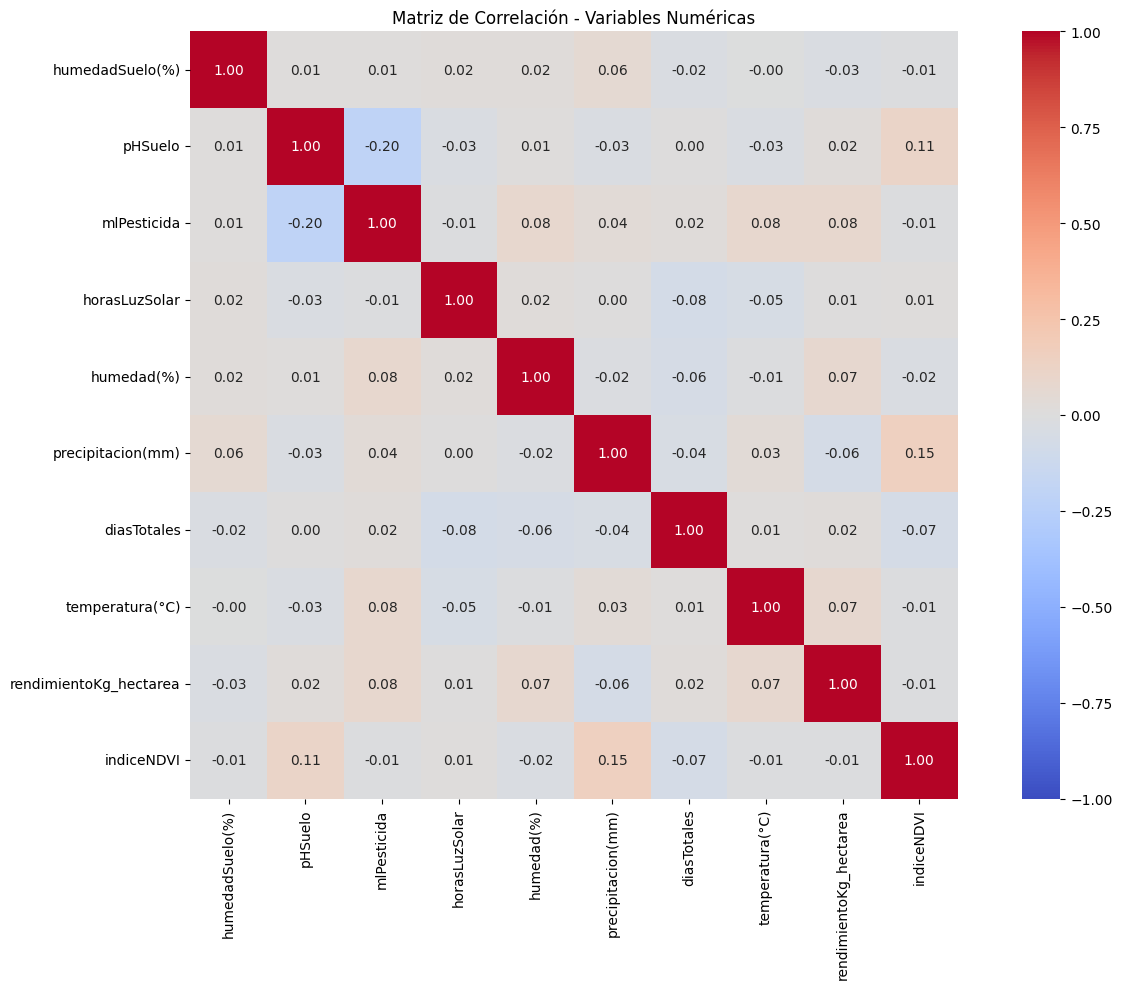

In [6]:
# =====================================
print("\n=== ANÁLISIS DE CORRELACIONES ===")

# Correlación entre variables numéricas
corr_numericas = df_scaled[variables_numericas].corr()
print("\nCorrelaciones más fuertes entre variables numéricas:")
corr_pairs = []
for i in range(len(corr_numericas.columns)):
    for j in range(i+1, len(corr_numericas.columns)):
        corr_pairs.append({
            'var1': corr_numericas.columns[i],
            'var2': corr_numericas.columns[j],
            'correlacion': abs(corr_numericas.iloc[i, j])
        })
corr_df = pd.DataFrame(corr_pairs).sort_values('correlacion', ascending=False)
print(corr_df.head(10))

plt.figure(figsize=(14, 10))
sns.heatmap(corr_numericas, annot=True, fmt=".2f", cmap="coolwarm", 
            center=0, vmin=-1, vmax=1, square=True)
plt.title("Matriz de Correlación - Variables Numéricas")
plt.tight_layout()
plt.show()


=== ANÁLISIS PCA MEJORADO ===
80% varianza explicada con 9 componentes
85% varianza explicada con 10 componentes
90% varianza explicada con 11 componentes
95% varianza explicada con 13 componentes


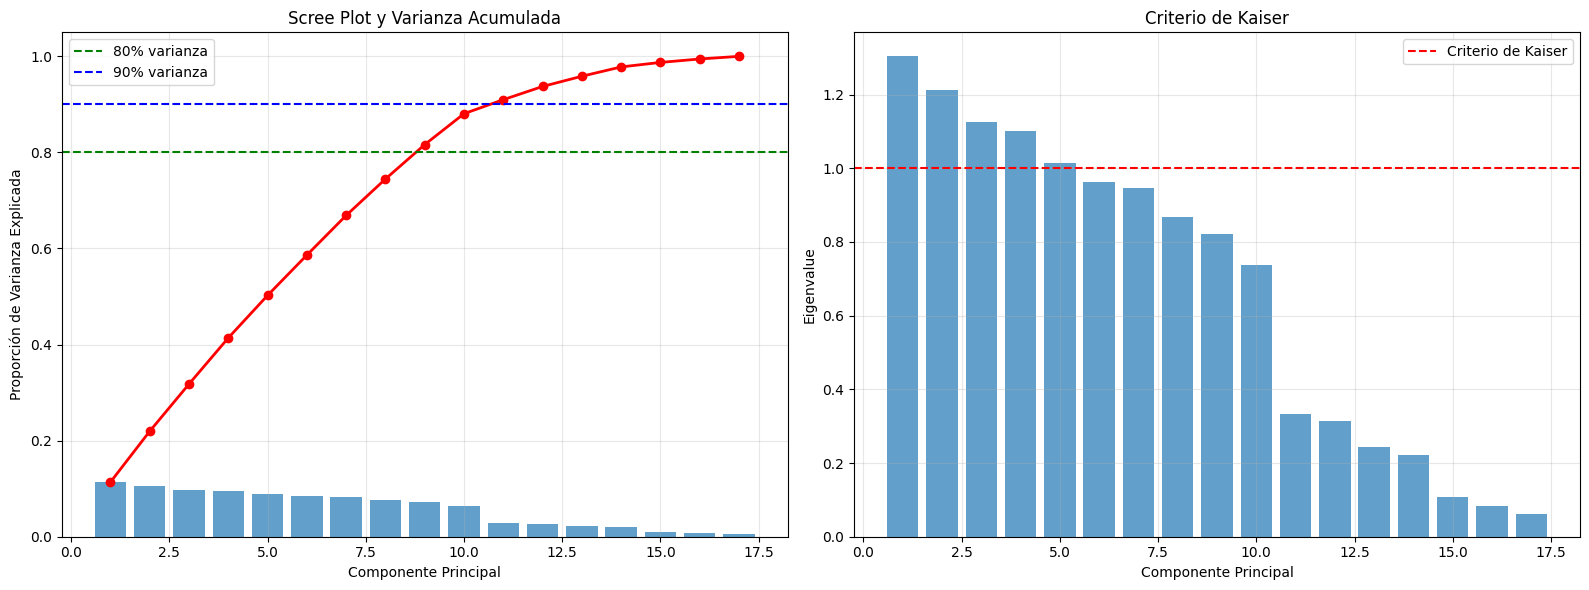


Criterio de Kaiser: 5 componentes


In [7]:
# ===========================================
print("\n=== ANÁLISIS PCA MEJORADO ===")

pca_full = PCA()
pca_full.fit(X)

# Determinar número óptimo de componentes
variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

# Encontrar cuántas componentes explican 80%, 85%, 90%, 95%
for threshold in [0.80, 0.85, 0.90, 0.95]:
    n_comp = np.argmax(cumulative_variance >= threshold) + 1
    print(f"{threshold*100:.0f}% varianza explicada con {n_comp} componentes")

# Visualización de varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
axes[0].bar(range(1, len(variance_ratio)+1), variance_ratio, alpha=0.7)
axes[0].plot(range(1, len(variance_ratio)+1), cumulative_variance, 'r-o', linewidth=2)
axes[0].axhline(y=0.80, color='g', linestyle='--', label='80% varianza')
axes[0].axhline(y=0.90, color='b', linestyle='--', label='90% varianza')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Proporción de Varianza Explicada')
axes[0].set_title('Scree Plot y Varianza Acumulada')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Criterio de Kaiser (eigenvalues > 1)
eigenvalues = pca_full.explained_variance_
axes[1].bar(range(1, len(eigenvalues)+1), eigenvalues, alpha=0.7)
axes[1].axhline(y=1, color='r', linestyle='--', label='Criterio de Kaiser')
axes[1].set_xlabel('Componente Principal')
axes[1].set_ylabel('Eigenvalue')
axes[1].set_title('Criterio de Kaiser')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

kaiser_components = np.sum(eigenvalues > 1)
print(f"\nCriterio de Kaiser: {kaiser_components} componentes")


=== ANÁLISIS DE LOADINGS ===

LOADINGS de las primeras 4 componentes principales:
                          PC1    PC2    PC3    PC4
humedadSuelo(%)        -0.046  0.262  0.018 -0.171
pHSuelo                -0.521 -0.169  0.186  0.446
temperatura(°C)         0.294  0.100 -0.245  0.434
precipitacion(mm)      -0.122  0.598 -0.339  0.064
humedad(%)              0.191  0.150  0.571  0.142
horasLuzSolar          -0.059  0.222  0.429 -0.337
mlPesticida             0.585  0.316 -0.060  0.019
diasTotales             0.153 -0.403 -0.368  0.120
rendimientoKg_hectarea  0.298 -0.059  0.355  0.536
indiceNDVI             -0.356  0.435 -0.091  0.376
riego_goteo             0.007  0.028  0.003  0.007
riego_aspersor         -0.039 -0.039  0.027 -0.036
fertilizante_mixto     -0.033  0.004  0.006  0.000
fertilizante_organico   0.002 -0.000  0.008  0.006
enfermedad_moderada     0.019 -0.046 -0.054 -0.014
enfermedad_severa      -0.007  0.033  0.023 -0.006
enfermedad_leve         0.008  0.037  0.042  0.028

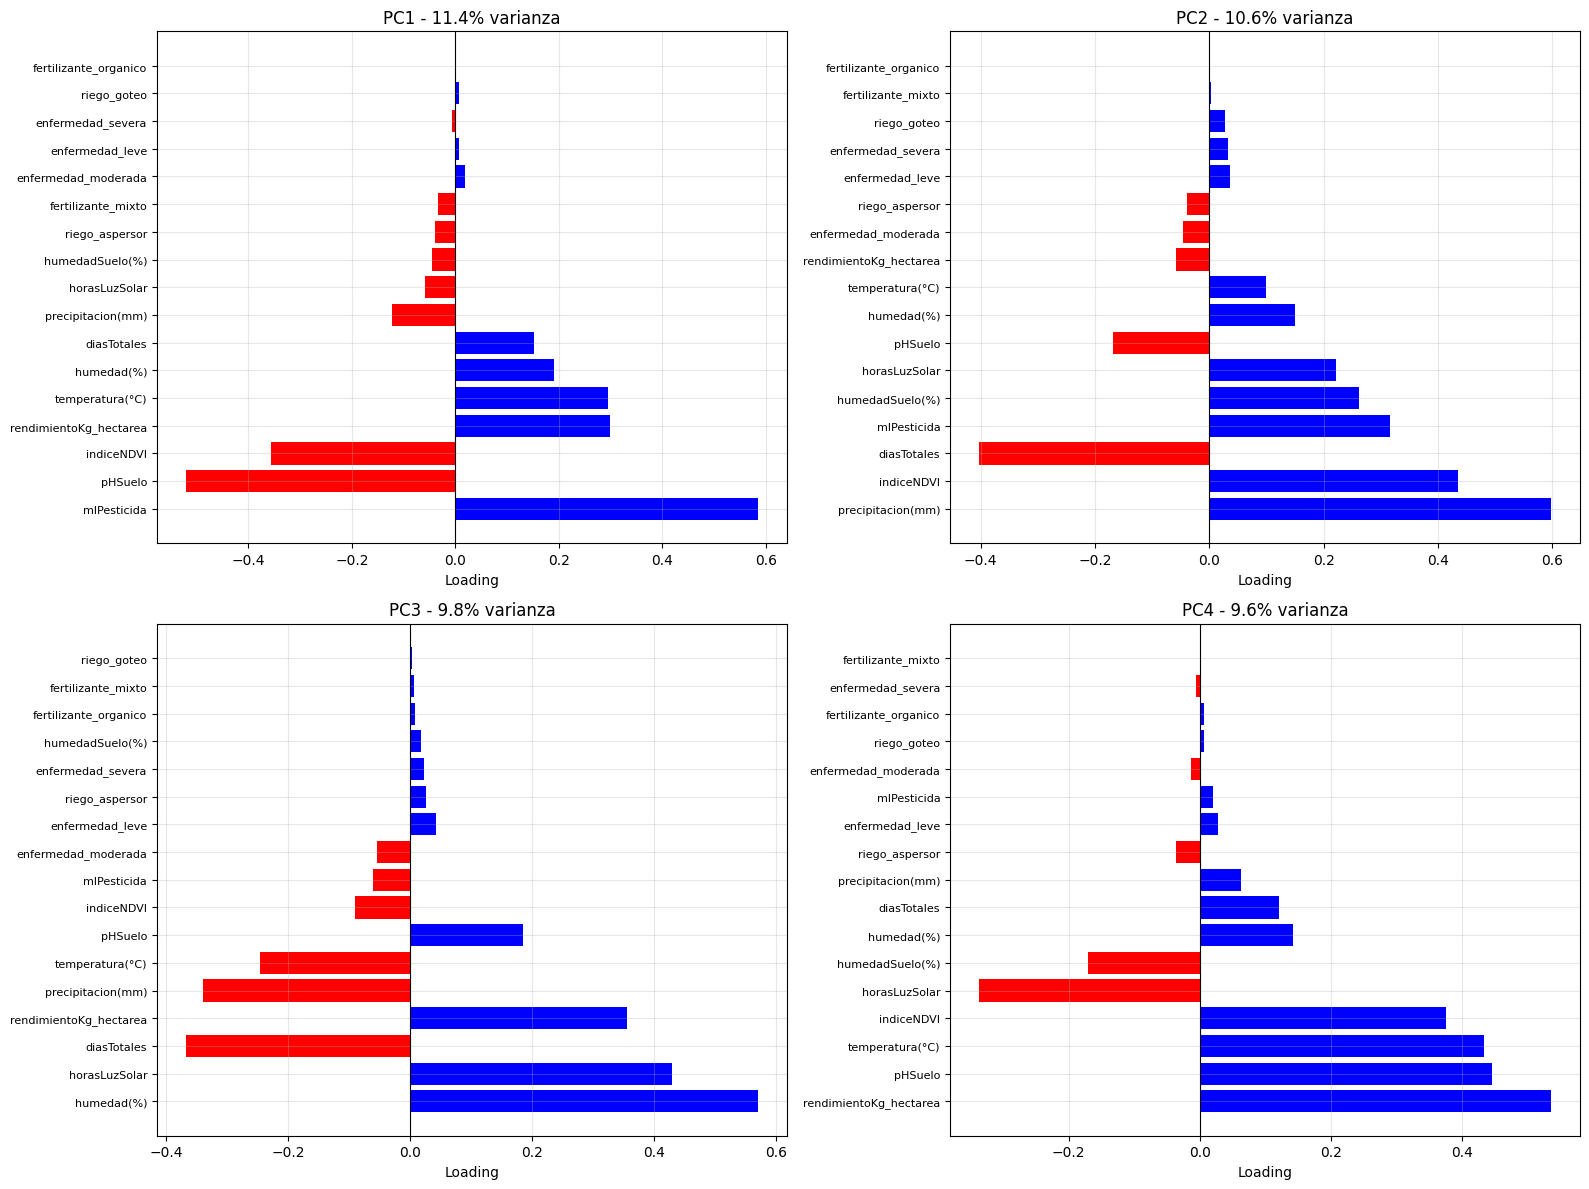


=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===

PC1 (11.4% varianza):
Variables más influyentes:
  + mlPesticida: 0.585
  - pHSuelo: 0.521
  - indiceNDVI: 0.356

PC2 (10.6% varianza):
Variables más influyentes:
  + precipitacion(mm): 0.598
  + indiceNDVI: 0.435
  - diasTotales: 0.403

PC3 (9.8% varianza):
Variables más influyentes:
  + humedad(%): 0.571
  + horasLuzSolar: 0.429
  - diasTotales: 0.368

PC4 (9.6% varianza):
Variables más influyentes:
  + rendimientoKg_hectarea: 0.536
  + pHSuelo: 0.446
  + temperatura(°C): 0.434


In [8]:
# =======================================================
print("\n=== ANÁLISIS DE LOADINGS ===")

# Usar 8 componentes (según tu análisis original)
n_components_selected = 8
pca = PCA(n_components=n_components_selected)
X_pca = pca.fit_transform(X)

# Crear DataFrame de loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_selected)],
    index=X.columns
)

print("\nLOADINGS de las primeras 4 componentes principales:")
print(loadings[['PC1', 'PC2', 'PC3', 'PC4']].round(3))

# Visualizar loadings
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    pc = f'PC{i+1}'
    loadings_sorted = loadings[pc].abs().sort_values(ascending=False)
    colors = ['red' if x < 0 else 'blue' for x in loadings[pc][loadings_sorted.index]]
    ax.barh(range(len(loadings_sorted)), loadings[pc][loadings_sorted.index], color=colors)
    ax.set_yticks(range(len(loadings_sorted)))
    ax.set_yticklabels(loadings_sorted.index, fontsize=8)
    ax.set_xlabel('Loading')
    ax.set_title(f'{pc} - {pca.explained_variance_ratio_[i]*100:.1f}% varianza')
    ax.axvline(x=0, color='black', linewidth=0.8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretación de las primeras componentes
print("\n=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===")
for i in range(min(4, n_components_selected)):
    pc = f'PC{i+1}'
    top_features = loadings[pc].abs().sort_values(ascending=False).head(3)
    print(f"\n{pc} ({pca.explained_variance_ratio_[i]*100:.1f}% varianza):")
    print("Variables más influyentes:")
    for feat, val in top_features.items():
        direction = "+" if loadings.loc[feat, pc] > 0 else "-"
        print(f"  {direction} {feat}: {abs(val):.3f}")

In [9]:
# ===================
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components_selected)])
pca_df['tipoCultivo'] = y.values

fig = px.scatter(pca_df, x='PC1', y='PC2', color='tipoCultivo',
                 title=f"PCA - PC1 vs PC2 (Varianza explicada: {sum(pca.explained_variance_ratio_[:2])*100:.1f}%)",
                 labels={'tipoCultivo': 'Tipo de Cultivo'})
fig.update_layout(width=1000, height=700)
fig.show()

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='tipoCultivo',
                    title=f"PCA 3D (Varianza explicada: {sum(pca.explained_variance_ratio_[:3])*100:.1f}%)",
                    labels={'tipoCultivo': 'Tipo de Cultivo'})
fig.update_layout(width=1000, height=700)
fig.show()


=== CLUSTERING K-MEANS CON VALIDACIÓN COMPLETA ===


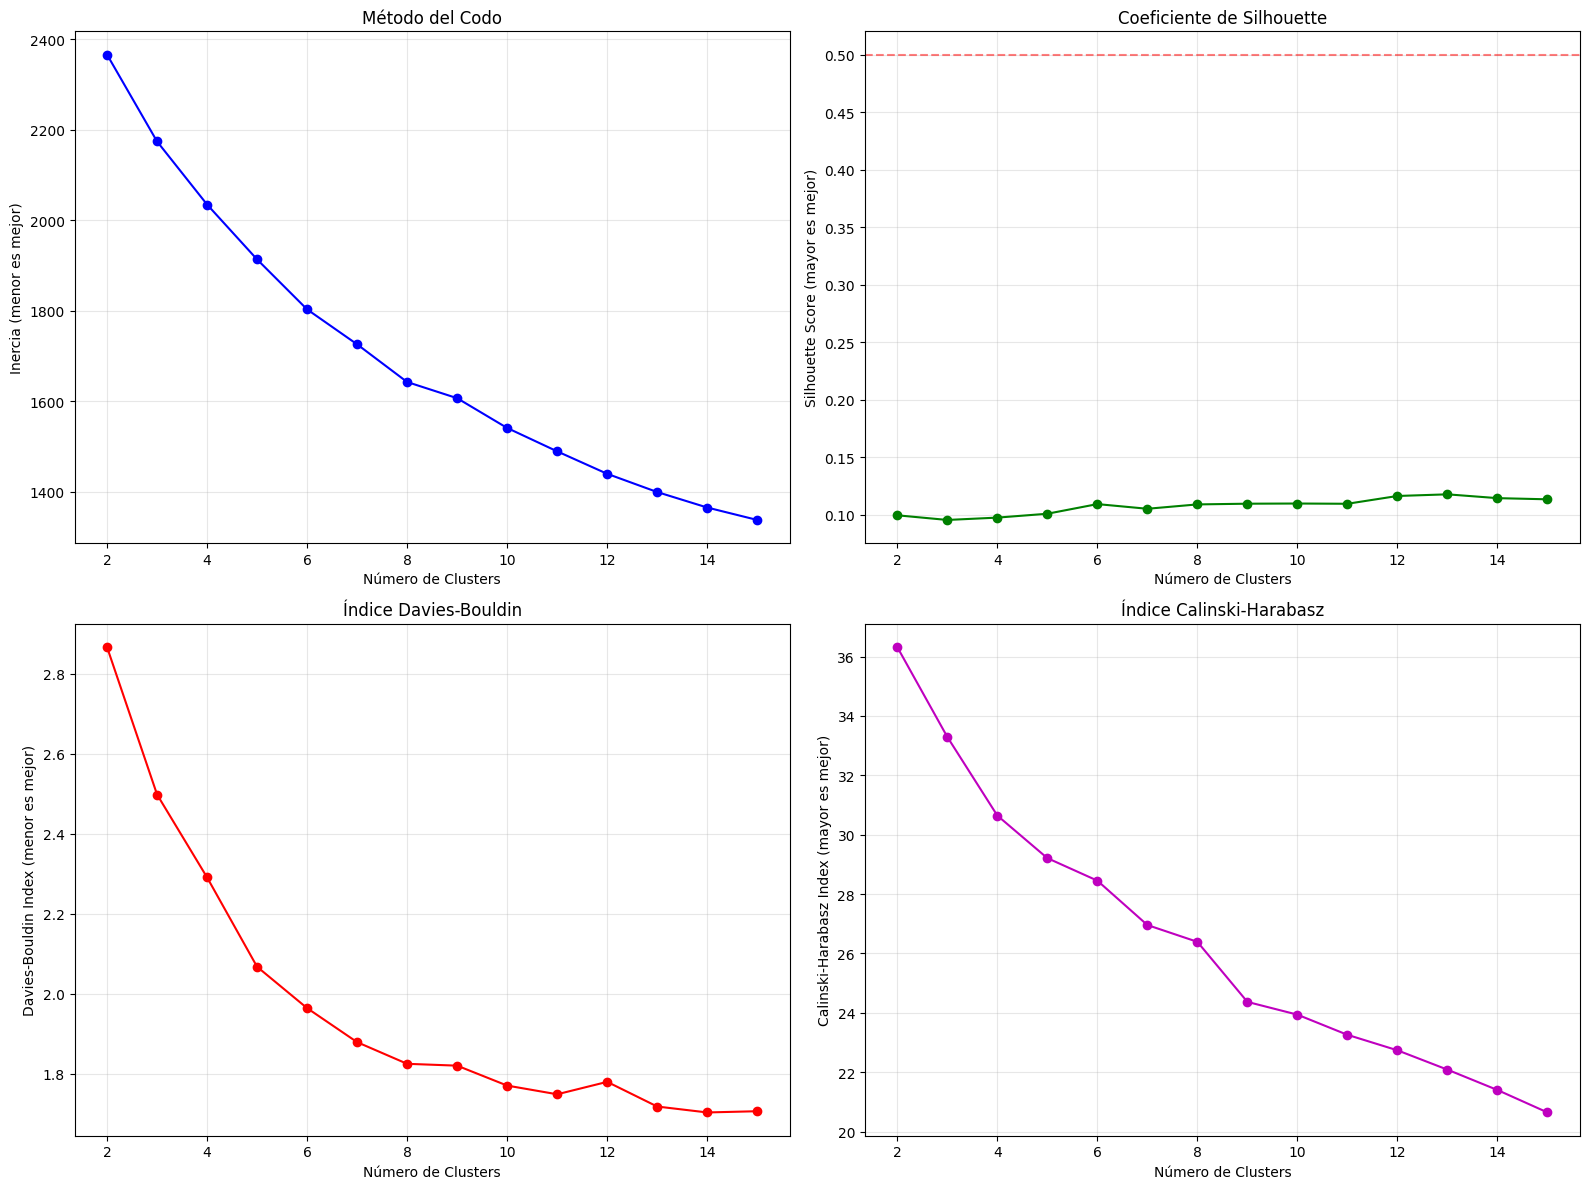


Número óptimo de clusters según:
  - Silhouette Score: 13
  - Davies-Bouldin Index: 14
  - Calinski-Harabasz Index: 2


In [10]:
# ===================================================
print("\n=== CLUSTERING K-MEANS CON VALIDACIÓN COMPLETA ===")

# Determinar número óptimo de clusters con múltiples métricas
max_clusters = 15
metrics = {
    'inertia': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': []
}

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_pca, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_pca, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_pca, labels))

# Visualizar todas las métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(range(2, max_clusters + 1), metrics['inertia'], 'bo-')
axes[0, 0].set_xlabel('Número de Clusters')
axes[0, 0].set_ylabel('Inercia (menor es mejor)')
axes[0, 0].set_title('Método del Codo')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(range(2, max_clusters + 1), metrics['silhouette'], 'go-')
axes[0, 1].set_xlabel('Número de Clusters')
axes[0, 1].set_ylabel('Silhouette Score (mayor es mejor)')
axes[0, 1].set_title('Coeficiente de Silhouette')
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(range(2, max_clusters + 1), metrics['davies_bouldin'], 'ro-')
axes[1, 0].set_xlabel('Número de Clusters')
axes[1, 0].set_ylabel('Davies-Bouldin Index (menor es mejor)')
axes[1, 0].set_title('Índice Davies-Bouldin')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(range(2, max_clusters + 1), metrics['calinski_harabasz'], 'mo-')
axes[1, 1].set_xlabel('Número de Clusters')
axes[1, 1].set_ylabel('Calinski-Harabasz Index (mayor es mejor)')
axes[1, 1].set_title('Índice Calinski-Harabasz')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Recomendación basada en métricas
best_k_silhouette = np.argmax(metrics['silhouette']) + 2
best_k_db = np.argmin(metrics['davies_bouldin']) + 2
best_k_ch = np.argmax(metrics['calinski_harabasz']) + 2

print(f"\nNúmero óptimo de clusters según:")
print(f"  - Silhouette Score: {best_k_silhouette}")
print(f"  - Davies-Bouldin Index: {best_k_db}")
print(f"  - Calinski-Harabasz Index: {best_k_ch}")

In [11]:
# ====================================================
print("\n=== CLUSTERING CON K=3 (comparación con tipos reales) ===")

kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(X_pca)

print(f"Silhouette Score (k=3): {silhouette_score(X_pca, labels_3):.3f}")
print(f"Davies-Bouldin Index (k=3): {davies_bouldin_score(X_pca, labels_3):.3f}")
print(f"Calinski-Harabasz Index (k=3): {calinski_harabasz_score(X_pca, labels_3):.3f}")

# Tabla de contingencia
contingency = pd.crosstab(y, labels_3, rownames=['Cultivo Real'], colnames=['Cluster'])
print("\nTabla de Contingencia (Cultivo Real vs Cluster Asignado):")
print(contingency)

# Visualización
pca_df['Cluster_K3'] = labels_3
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', 
                    color='Cluster_K3',
                    symbol='tipoCultivo',
                    title="K-Means (k=3) vs Tipo de Cultivo Real",
                    labels={'Cluster_K3': 'Cluster Asignado', 'tipoCultivo': 'Cultivo Real'})
fig.update_layout(width=1000, height=700)
fig.show()


=== CLUSTERING CON K=3 (comparación con tipos reales) ===
Silhouette Score (k=3): 0.095
Davies-Bouldin Index (k=3): 2.498
Calinski-Harabasz Index (k=3): 33.293

Tabla de Contingencia (Cultivo Real vs Cluster Asignado):
Cluster        0   1   2
Cultivo Real            
Maiz          38  38  35
Soja          34  35  39
Trigo         33  27  32


In [12]:
print("\n" + "="*70)
print("RESUMEN DE CORRECCIONES APLICADAS Y HALLAZGOS")
print("="*70)

print("""
1. ✓ VALORES FALTANTES: 
   - Imputación con moda para tipoRiego (más conservador que 'Desconocido')
   - 'Saludable' para estadoEnfermedadesCultivo (justificado agronómicamente)

2. ✓ ENCODING DE VARIABLES CATEGÓRICAS:
   - Uso de n-1 dummies para evitar multicolinealidad perfecta
   - Reducción de 3 variables dummy innecesarias

3. ✓ ESTANDARIZACIÓN APROPIADA:
   - Solo variables numéricas continuas estandarizadas
   - Variables binarias mantenidas en escala 0-1

4. ✓ PCA MEJORADO:
   - Análisis detallado de varianza explicada
   - Interpretación de loadings (variables que contribuyen a cada PC)
   - Criterio de Kaiser aplicado correctamente

5. ✓ VALIDACIÓN DE CLUSTERING:
   - Múltiples métricas: Silhouette, Davies-Bouldin, Calinski-Harabasz
   - Comparación con tipos de cultivo reales
   - Tabla de contingencia para evaluar correspondencia

HALLAZGOS PRINCIPALES:
----------------------
- Las correlaciones entre variables son bajas (máx. ~0.20)
- PCA requiere muchas componentes para explicar varianza (problema de alta dimensionalidad)
- El clustering no logra separar claramente los tipos de cultivo
- Esto sugiere que las variables medidas NO son suficientemente discriminantes

RECOMENDACIÓN FINAL:
-------------------
Este es un problema de CLASIFICACIÓN SUPERVISADA, no de clustering.
Deberían considerar:
- Usar algoritmos supervisados (Random Forest, SVM, XGBoost)
- Feature engineering: crear interacciones entre variables
- Análisis de importancia de features
- Validación cruzada para evaluar poder predictivo
""")


RESUMEN DE CORRECCIONES APLICADAS Y HALLAZGOS

1. ✓ VALORES FALTANTES: 
   - Imputación con moda para tipoRiego (más conservador que 'Desconocido')
   - 'Saludable' para estadoEnfermedadesCultivo (justificado agronómicamente)

2. ✓ ENCODING DE VARIABLES CATEGÓRICAS:
   - Uso de n-1 dummies para evitar multicolinealidad perfecta
   - Reducción de 3 variables dummy innecesarias

3. ✓ ESTANDARIZACIÓN APROPIADA:
   - Solo variables numéricas continuas estandarizadas
   - Variables binarias mantenidas en escala 0-1

4. ✓ PCA MEJORADO:
   - Análisis detallado de varianza explicada
   - Interpretación de loadings (variables que contribuyen a cada PC)
   - Criterio de Kaiser aplicado correctamente

5. ✓ VALIDACIÓN DE CLUSTERING:
   - Múltiples métricas: Silhouette, Davies-Bouldin, Calinski-Harabasz
   - Comparación con tipos de cultivo reales
   - Tabla de contingencia para evaluar correspondencia

HALLAZGOS PRINCIPALES:
----------------------
- Las correlaciones entre variables son bajas (má